This notebook implements a three-dimensional flocking simulation and compares its emergent properties to empirical measurements of starling flocks reported in the reference paper. The goal is to test whether simple local interaction rules can reproduce the large-scale geometric and density scaling observed in real biological systems.

* Density vs Flock size: examining whether flock density remains approximately independent of the number of individuals, as observed in real starling flocks.

* Thickness vs $V^{\frac{1}{3}}$: testing the geometric scaling law where flock thickness increases proportionally with the cube root of flock volume, indicating self-similar growth.

* Aspect Ratios vs Flock Size: nvestigating whether flock shape proportions remain roughly constant as the flock size increases.

In [2]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS
from src.config import SimConfig, MetricsConfig


SIM = SimConfig(
    N=300,
    steps=1500,
    save_every=30,
    attraction=0.0,      
    noise=0.03,
    interaction_range=0.30,
)

MET = MetricsConfig(
    eps=0.06,              #
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

[bootstrap] PROJECT_ROOT = /Users/tonyvo/Desktop/project_comp_sci
[bootstrap] RESULTS_DIR  = /Users/tonyvo/Desktop/project_comp_sci/results
[bootstrap] FIGURES_DIR  = /Users/tonyvo/Desktop/project_comp_sci/figures


In [9]:
import numpy as np
import matplotlib.pyplot as plt

from src.flocking_sim_3d import run_simulation


# Default Flocking Model Settings
box_size = 1.0
eps = 0.05
steps = 400
N = 200
align=1.0
cohesion=0.5           
noise=0.05
R=0.15
speed=0.03
repulsion_radius=0.05
repulsion_strength=1.0


# Density vs Flock Size (N)


The first experiment tests how the size and shape of the simulated flock scale with the number of agents. For each flock size 
N, the simulation box was scaled as $N^{\frac{1}{3}}$ to prevent forced density increases. After each simulation reaches a steady state, the flock volume is estimated using a PCA-based ellipsoidal approximation, and density is computed as the number of agents divided by this volume.

A PCA-based ellipsoidal volume approximation is used for density measurements because it provides a smooth global size estimate and does not require detailed knowledge of the flock’s exact shape.



In [ ]:
def flock_volume_from_pca(pos, box_size=None):
    """
    Approximates flock volume using principal dimensions (ellipsoid).
    """
    
    X = pos.copy()

    # adjust for periodic boundary conditions
    if box_size is not None:
        # unwrap relative to center of mass (com)
        com = X.mean(axis=0)
        rel = X - com
        rel -= box_size * np.round(rel / box_size)
        X = com + rel

    # center flock position around the origin
    Xc = X - X.mean(axis=0)

    # compute covariance matrix describing flock spatial spread - result in a 3x3 matrix
    C = (Xc.T @ Xc) / Xc.shape[0]

    #PCA Eigendecomposition to get new axes
    evals, _ = np.linalg.eigh(C)
    evals = np.sort(evals)[::-1]

    # principal spatial dimensions (length, width, thickness)
    I3, I2, I1 = np.sqrt(np.maximum(evals, 0))

    # approximate flock volume using equivalent ellipsoid
    V = (4/3) * np.pi * I1 * I2 * I3

    return V, (I1, I2, I3)


def flock_density(pos, box_size=None):
    N = pos.shape[0]          # number of birds
    V, _ = flock_volume_from_pca(pos, box_size)
    density = N / V
    return density



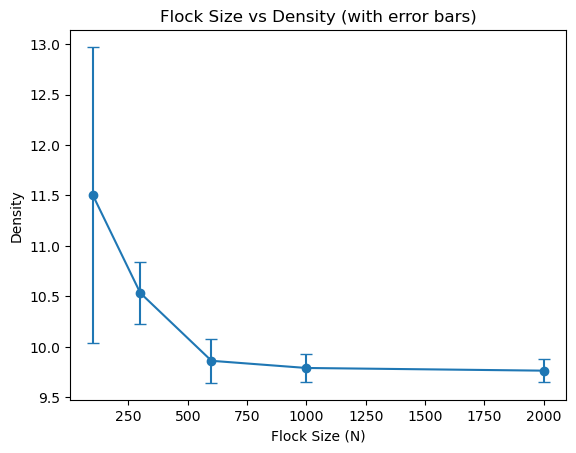

In [12]:
N = [100, 300, 600, 1000, 2000]
n_runs = 5   # number of simulations per N

dens_mean = []
dens_std = []

for n in N:
    dens_list = []

    for seed in range(n_runs):

        box_size = n**(1/3)
        R = 0.2 * box_size
        repulsion_radius = 0.1 * box_size

        position = run_simulation(
            N=n,
            steps=steps,
            box_size=box_size,
            align=align,
            cohesion=cohesion,               
            noise=noise,
            R=R,
            speed=speed,
            repulsion_radius=repulsion_radius,
            repulsion_strength=repulsion_strength,
            use_predator=False,
            dt=0.1,
            seed=seed,     # different seed each run
            save_every=1,
            softening=1e-6,
        )

        dens_list.append(
            flock_density(position[-1], box_size=box_size)
        )

    dens_mean.append(np.mean(dens_list))
    dens_std.append(np.std(dens_list))

# ---- Plot ----

plt.figure()

plt.errorbar(
    N,
    dens_mean,
    yerr=dens_std,
    fmt='o-',
    capsize=4
)

plt.xlabel("Flock Size (N)")
plt.ylabel("Density")
plt.title("Flock Size vs Density (with error bars)")
plt.savefig("../figures/flock_density_N.png", dpi=200)
plt.show()


After correcting for container effects by scaling system size with flock size, the simulation exhibits approximately size-independent density, consistent with empirical measurements of starling flocks. The density decreases slightly for small flock sizes (100-600) and rapidly approaches a constant value as flock size increases. For larger flocks, density remains approximately independent of the number of agents, consistent with empirical observations of real starling flocks.

# Thickness vs Volume

To characterize the three-dimensional structure of the simulated flock, we analyze the final agent positions by applying principal component analysis (PCA) to the covariance matrix of the spatial coordinates. This method identifies three orthogonal directions along which the spatial spread of the aggregation is largest by taking the eigenvectors of this matrix and the corresponding eigenvalues quantify the spread of the flock along these directions. The resulting principal dimensions represent the main geometric extents of the flock: $I_{3}$ the largest dimension captures the overall length of the flock, $I_{2}$ the intermediate dimension describes its width, and $I_{1}$ the smallest dimension corresponds to the flock’s thickness.

The second experiment examines how flock thickness scales with the overall flock size by plotting the smallest PCA dimension, $I_{1}$, against the cube root of the flock volume for increasing numbers of agents. As the number of agents increases, the emergent flock volume grows. We compare the flock thickness to the cube root of this volume, which represents a linear size scale of the flock, to test whether larger flocks are geometrically scaled versions of smaller ones. The flock volume V is estimated using the convex hull of the agent positions, which approximates the true occupied space of the aggregation.

The convex hull volume is used to approximate the true space occupied by the flock by enclosing all agent positions within the smallest convex polyhedron. This provides a realistic measure of flock size needed to relate thickness to overall geometric scale.

# Aspect ratio vs Flock Size

The geometric proportions of the flock are characterized using aspect ratios defined as the ratios between the larger and smaller principal spatial dimensions, specifically $I_{2} / I_{1}$ and $I_{3} / I_{1}$. By examining how these quantities change with flock size, we can determine whether larger flocks preserve their overall shape while scaling in size, as observed in empirical studies of real starling flocks.

In [ ]:
from scipy.spatial import ConvexHull

def pca_axes(pos):
    X = pos - pos.mean(axis=0) # center positions at the flock's center of mass
    C = (X.T @ X) / X.shape[0]  # compute covariance matrix of spatial spread
    evals, _ = np.linalg.eigh(C) # eigenvalues of covariance (PCA)
    evals = np.sort(evals)[::-1] 
    # Axis-length proxies from variances along principal directions
    I3, I2, I1 = np.sqrt(np.maximum(evals, 0))
    return I1, I2, I3

def hull_volume(pos):
    # Convex hull volume proxy
    hull = ConvexHull(pos)
    return hull.volume

In [ ]:
Ns = [100, 300, 600, 1000, 2000]
results = []

for n in Ns:
    V13_list = []
    I1_list = []
    I2I1_list = []
    I3I1_list = []
    box_size = n**(1/3)  # scaling box size so the flock volume is not artifically constrained.

    history = run_simulation(
        N=n,
        box_size=box_size,
        R=0.2 * box_size,
        repulsion_radius=0.1 * box_size,
        cohesion=0.2,
        repulsion_strength=2.0,
        align=1.0,
        noise=0.1,
        steps=600,
        seed=42
    )

    pos = history[-1]
    V = hull_volume(pos)
    I1, I2, I3 = pca_axes(pos)

    V13_list.append(V**(1/3))
    I1_list.append(I1)
    I2I1_list.append(I2 / (I1 + 1e-12))
    I3I1_list.append(I3 / (I1 + 1e-12))

    results.append({
        "N": n,
        "V13_mean": np.mean(V13_list),
        "V13_std": np.std(V13_list),
        "I1_mean": np.mean(I1_list),
        "I1_std": np.std(I1_list),
        "I2I1_mean": np.mean(I2I1_list),
        "I2I1_std": np.std(I2I1_list),
        "I3I1_mean": np.mean(I3I1_list),
        "I3I1_std": np.std(I3I1_list),
    })


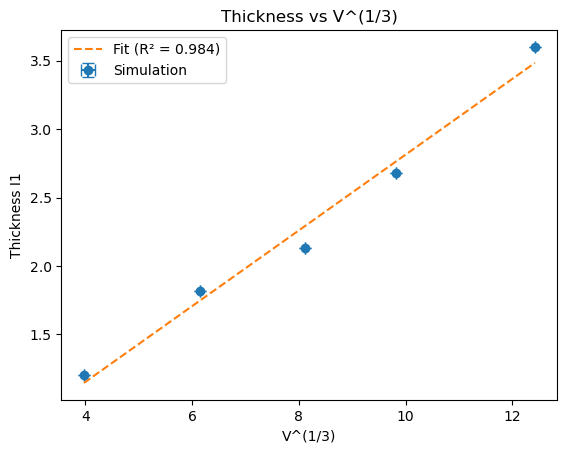

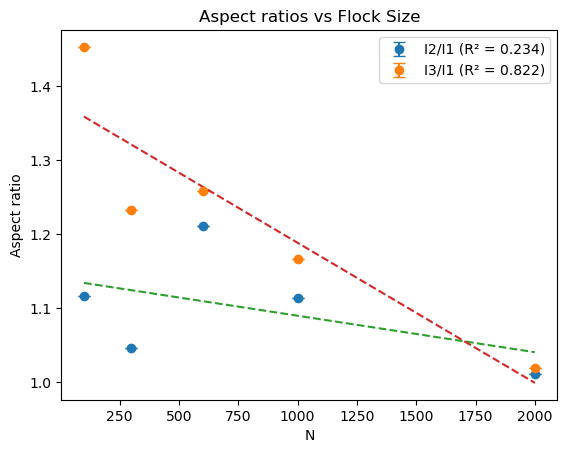

In [14]:
V13_mean = [r["V13_mean"] for r in results]
V13_std  = [r["V13_std"]  for r in results]

I1_mean  = [r["I1_mean"] for r in results]
I1_std   = [r["I1_std"]  for r in results]

I2I1_mean = [r["I2I1_mean"] for r in results]
I2I1_std  = [r["I2I1_std"]  for r in results]

I3I1_mean = [r["I3I1_mean"] for r in results]
I3I1_std  = [r["I3I1_std"]  for r in results]


# linear fit
coef = np.polyfit(V13_mean, I1_mean, 1)
fit_line = np.polyval(coef, V13_mean)

# R^2
ss_res = np.sum((np.array(I1_mean) - fit_line)**2)
ss_tot = np.sum((np.array(I1_mean) - np.mean(I1_mean))**2)
r2 = 1 - ss_res/ss_tot

plt.figure()
plt.errorbar(V13_mean, I1_mean, yerr=I1_std, xerr=V13_std,
             fmt='o', capsize=4, label="Simulation")

plt.plot(V13_mean, fit_line, '--', label=f"Fit (R² = {r2:.3f})")

plt.xlabel("V^(1/3)")
plt.ylabel("Thickness I1")
plt.title("Thickness vs V^(1/3)")
plt.savefig("../figures/flock_thickness_V.png", dpi=200)
plt.legend()
plt.show()


# --- Linear fits for aspect ratios ---

# Fit I2/I1 vs N
coef_I2 = np.polyfit(Ns, I2I1_mean, 1)
fit_I2 = np.polyval(coef_I2, Ns)

ss_res_I2 = np.sum((np.array(I2I1_mean) - fit_I2)**2)
ss_tot_I2 = np.sum((np.array(I2I1_mean) - np.mean(I2I1_mean))**2)
r2_I2 = 1 - ss_res_I2 / ss_tot_I2


# Fit I3/I1 vs N
coef_I3 = np.polyfit(Ns, I3I1_mean, 1)
fit_I3 = np.polyval(coef_I3, Ns)

ss_res_I3 = np.sum((np.array(I3I1_mean) - fit_I3)**2)
ss_tot_I3 = np.sum((np.array(I3I1_mean) - np.mean(I3I1_mean))**2)
r2_I3 = 1 - ss_res_I3 / ss_tot_I3



plt.figure()

plt.errorbar(
    Ns, I2I1_mean, yerr=I2I1_std,
    fmt='o', capsize=4,
    label=f"I2/I1 (R² = {r2_I2:.3f})"
)

plt.errorbar(
    Ns, I3I1_mean, yerr=I3I1_std,
    fmt='o', capsize=4,
    label=f"I3/I1 (R² = {r2_I3:.3f})"
)

plt.plot(Ns, fit_I2, '--')
plt.plot(Ns, fit_I3, '--')

plt.xlabel("N")
plt.ylabel("Aspect ratio")
plt.title("Aspect ratios vs Flock Size")
plt.savefig("../figures/flock_aspect_ratio_N.png", dpi=200)
plt.legend()
plt.show()



Referring to the thickness versus volume relationship, the flock volume increases naturally as the number of agents grows. Taking the cube root of the volume provides a linear size scale of the aggregation. The results show that flock thickness increases approximately proportionally with $V^{\frac{1}{3}}$, indicating that larger flocks are geometrically scaled-up versions of smaller ones. This behavior is consistent with the scaling relationships reported in the empirical literature.

Regarding the aspect ratios vs flock size graph, both ratios show a downward trend as N increases meaning small flocks are more elongated and larger flocks become compact and isotropic. However, aspect ratio values stay between 1.0 and 1.5 suggesting that flock shapes are broadly preserved. The qualitative behavior is consistent with empirical observations that flock geometry does not strongly scale with flock size.